In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Loading dataset
# First column is the timestamp (no header), so setting it as the index and parsing as dates
data = pd.read_csv("merged_energy_weather.csv", index_col=0, parse_dates=True)

# Displaying first few rows
print(data.head())
print(data.columns)
print(data.index)

                           COMED_MW  temp_AUR  temp_BC  temp_DKC  temp_FRE  \
2011-01-01 07:00:00+00:00    9631.0       3.3      5.0       3.3  0.247652   
2011-01-01 08:00:00+00:00    9273.0       2.2      3.9       2.2 -0.080259   
2011-01-01 09:00:00+00:00    9011.0       0.6      2.8       0.6 -2.542620   
2011-01-01 10:00:00+00:00    8741.0      -0.6      0.6      -0.6 -3.816004   
2011-01-01 11:00:00+00:00    8694.0      -2.2     -0.6      -2.2 -5.277747   

                           temp_KAN  temp_LYN  temp_MDW  temp_ORD  temp_PON  \
2011-01-01 07:00:00+00:00  7.693101       6.1       6.1       4.4  7.747203   
2011-01-01 08:00:00+00:00  5.509144       4.4       4.4       2.8  5.497401   
2011-01-01 09:00:00+00:00  3.487656       3.3       3.3       2.2  3.186248   
2011-01-01 10:00:00+00:00  2.504727       2.2       2.2       0.0  1.946568   
2011-01-01 11:00:00+00:00  0.859336       0.6       0.6      -0.6  0.802695   

                           ...  prcp_ORD_prcp_WOG_merged

In [ ]:
# Adding time features
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

# Preparing features and target variable
target = 'COMED_MW'
features = [col for col in data.columns if col != target]

In [ ]:
# Splitting into train and test (80% train, 20% test, keeping order for time series)
split_idx = int(len(data) * 0.8)
X_train = data[features].iloc[:split_idx]
X_test = data[features].iloc[split_idx:]
y_train = data[target].iloc[:split_idx]
y_test = data[target].iloc[split_idx:]

In [ ]:
# Scaling the features and target
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

In [ ]:
# Turning data into sequences (past 24 hours to predict next hour)
def create_sequences(X, y, seq_length=24):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 24  # 24 hours
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, SEQ_LEN)

In [ ]:
# PyTorch Dataset and DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_seq, y_train_seq)
test_dataset = TimeSeriesDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
# Defining LSTM regression model
class EnergyLSTM(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=2):
        super(EnergyLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]  # Last time step
        return self.fc(out).squeeze(-1)

n_features = X_train_seq.shape[2]
model = EnergyLSTM(n_features)

In [ ]:
# Training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model.train()
    losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}, Train loss: {np.mean(losses):.4f}")

Epoch 1, Train loss: 0.0084
Epoch 2, Train loss: 0.0078
Epoch 3, Train loss: 0.0069
Epoch 4, Train loss: 0.0062
Epoch 5, Train loss: 0.0060
Epoch 6, Train loss: 0.0060
Epoch 7, Train loss: 0.0044
Epoch 8, Train loss: 0.0059
Epoch 9, Train loss: 0.0041
Epoch 10, Train loss: 0.0044
Epoch 11, Train loss: 0.0041
Epoch 12, Train loss: 0.0037
Epoch 13, Train loss: 0.0041
Epoch 14, Train loss: 0.0036
Epoch 15, Train loss: 0.0041
Epoch 16, Train loss: 0.0028
Epoch 17, Train loss: 0.0033
Epoch 18, Train loss: 0.0030
Epoch 19, Train loss: 0.0031
Epoch 20, Train loss: 0.0028


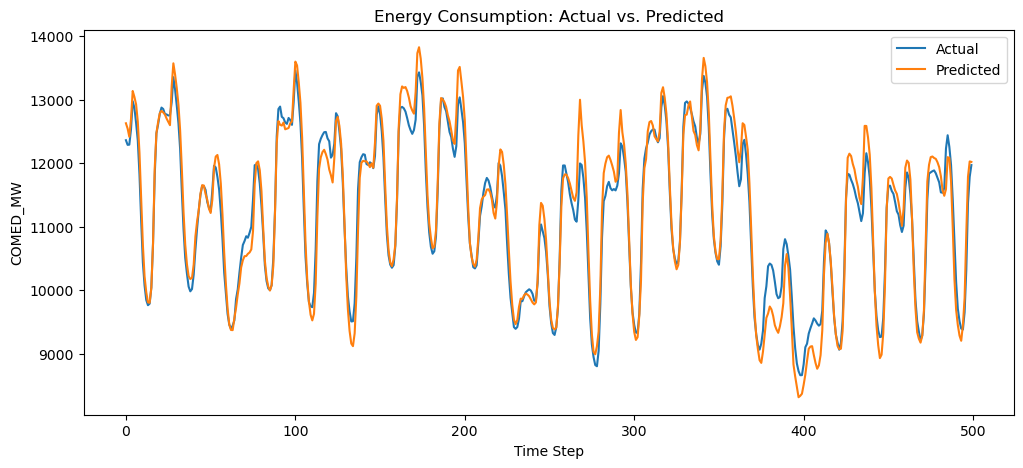

In [ ]:
# Evaluating the model on test set
model.eval()
with torch.no_grad():
    preds, actuals = [], []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        preds.append(y_pred.cpu().numpy())
        actuals.append(y_batch.numpy())

preds = np.concatenate(preds)
actuals = np.concatenate(actuals)

# Inverse transform to original MW units
preds_inverse = target_scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
actuals_inverse = target_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 5))
plt.plot(actuals_inverse[:500], label='Actual')
plt.plot(preds_inverse[:500], label='Predicted')
plt.legend()
plt.title('Energy Consumption: Actual vs. Predicted')
plt.xlabel('Time Step')
plt.ylabel('COMED_MW')
plt.show()


In [ ]:
# Using inverse-transformed predictions and actuals from plotting step
mae = mean_absolute_error(actuals_inverse, preds_inverse)
rmse = mean_squared_error(actuals_inverse, preds_inverse, squared=False)
mape = np.mean(np.abs((actuals_inverse - preds_inverse) / actuals_inverse)) * 100

print(f"Test MAE:  {mae:.2f} MW")
print(f"Test RMSE: {rmse:.2f} MW")
print(f"Test MAPE: {mape:.2f}%")


Test MAE:  374.36 MW
Test RMSE: 523.51 MW
Test MAPE: 3.37%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


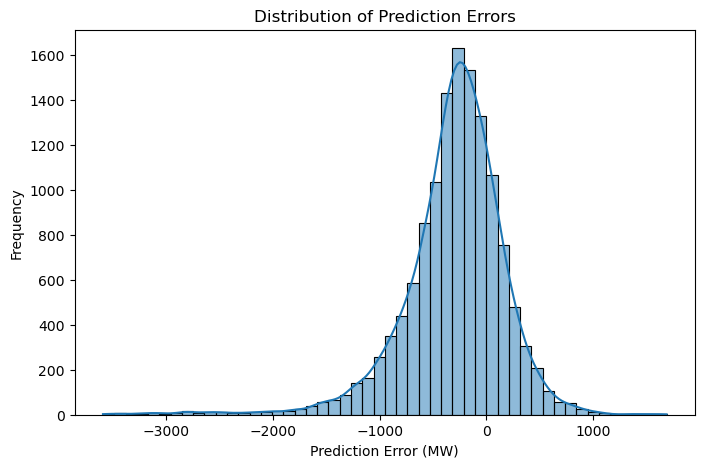

In [ ]:
# Difference between actual and predicted values
errors = actuals_inverse - preds_inverse
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=50, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (MW)')
plt.ylabel('Frequency')
plt.show()